In [827]:
import pandas as pd
import numpy as np

In [828]:
import warnings
warnings.filterwarnings('ignore')

In [829]:
df = pd.read_csv('high_diamond_ranked_10min.csv')

In [830]:
df.notna().all().all() # No missing values found in dataset

True

Let's reorganize the dataframe. I want to split the different teams, then join them again in the same dataframe to create a cleaner dataset for our analysis.

In [831]:
df.columns

Index(['gameId', 'blueWins', 'blueWardsPlaced', 'blueWardsDestroyed',
       'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueHeralds',
       'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
       'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'blueCSPerMin', 'blueGoldPerMin', 'redWardsPlaced', 'redWardsDestroyed',
       'redFirstBlood', 'redKills', 'redDeaths', 'redAssists',
       'redEliteMonsters', 'redDragons', 'redHeralds', 'redTowersDestroyed',
       'redTotalGold', 'redAvgLevel', 'redTotalExperience',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redGoldDiff',
       'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin'],
      dtype='object')

In [832]:
blue_columns = ['gameId']
red_columns = ['gameId']

for col in df.columns:
    if 'blue' in col:
        blue_columns += [col]
    if 'red' in col:
        red_columns += [col]


In [833]:
blue_df = df[blue_columns]

In [834]:
blue_df['blueWins'].value_counts()

blueWins
0    4949
1    4930
Name: count, dtype: int64

In [835]:
red_df = df[red_columns]

In [836]:
red_df['redWins'] = 1 - df['blueWins']

In [837]:
red_df.head()

,gameId,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,...,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin,redWins
0,4519157822,15,6,0,6,9,8,0,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,1
1,4523371949,12,1,1,5,5,2,2,1,1,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,1
2,4521474530,15,3,1,11,7,14,0,0,0,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,1
3,4524384067,15,2,1,5,4,10,0,0,0,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1
4,4436033771,17,2,1,6,6,7,1,1,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,1


Let's first check the probability of Blue team winning

In [838]:
wins = df['blueWins']

In [839]:
wins.value_counts()[1]/len(wins)

0.4990383642069035

It seems that the value converges to 0.5
Let's conduct a t-test just to be sure

In [840]:
from scipy import stats

Ho: won games mean is 0.5 (no side has any advantage)

Ha: won games mean is different from 0.5 

In [841]:
t_statistic, p_value = stats.ttest_1samp(wins, 0.5)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: The mean is significantly different from 0.5")
else:
    print("Fail to reject the null hypothesis: The mean is not significantly different from 0.5")

T-statistic: -0.1911507162408147
P-value: 0.8484114428598137
Fail to reject the null hypothesis: The mean is not significantly different from 0.5


The P-value is very high, which means that there is a lot of reason to expect that the true population mean of the won games is 0.5

Therefore, we do not reject the null hypothesis.

Knowing that the side of the map has no statistical impact in the chances of winning, let's check some parameters that determine the winning chances.

In [842]:
blue_columns = blue_df.columns
blue_dict = {}

for col in blue_columns:
    if 'blue' in col:
        blue_dict[col] = col.replace('blue', '')


In [843]:
blue_df.rename(columns=blue_dict, inplace=True)

In [844]:
red_columns = red_df.columns
red_dict = {}

for col in red_columns:
    if 'red' in col:
        red_dict[col] = col.replace('red', '')

In [845]:
red_df.rename(columns=red_dict, inplace=True)

In [846]:
data = pd.concat([red_df, blue_df], ignore_index=True, sort=False)

In [847]:
len(data) == len(red_df) + len(blue_df)

True

In [848]:
(data['gameId'].value_counts() == 2).all() 

True

It seems that the data has been merged correctly

In [849]:
data.head()

,gameId,WardsPlaced,WardsDestroyed,FirstBlood,Kills,Deaths,Assists,EliteMonsters,Dragons,Heralds,...,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,GoldDiff,ExperienceDiff,CSPerMin,GoldPerMin,Wins
0,4519157822,15,6,0,6,9,8,0,0,0,...,16567,6.8,17047,197,55,-643,8,19.7,1656.7,1
1,4523371949,12,1,1,5,5,2,2,1,1,...,17620,6.8,17438,240,52,2908,1173,24.0,1762.0,1
2,4521474530,15,3,1,11,7,14,0,0,0,...,17285,6.8,17254,203,28,1172,1033,20.3,1728.5,1
3,4524384067,15,2,1,5,4,10,0,0,0,...,16478,7.0,17961,235,47,1321,7,23.5,1647.8,1
4,4436033771,17,2,1,6,6,7,1,1,0,...,17404,7.0,18313,225,67,1004,-230,22.5,1740.4,1


In [850]:
won = data[data['Wins']==1]
lost = data[data['Wins']==0]

In [851]:
import matplotlib.pyplot as plt

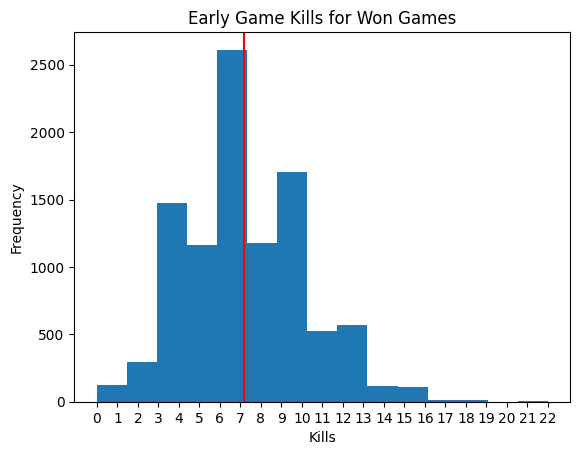

In [852]:
plt.hist(won['Kills'],15)
plt.xticks(range(0,max(data['Kills']+1)))
plt.title('Early Game Kills for Won Games')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.axvline(np.mean(won['Kills']), color='red')
plt.show()

We can see that, on average, the early game kills matter when it comes to improving your chances of winning the game

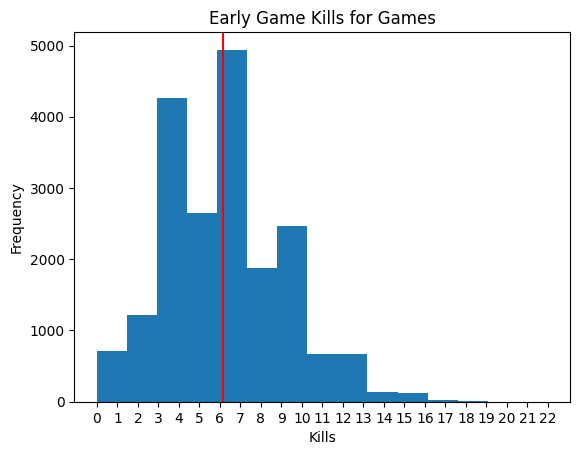

In [853]:
plt.hist(data['Kills'],15)
plt.title('Early Game Kills for Games')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.xticks(range(0,max(data['Kills']+1)))
plt.axvline(np.mean(data['Kills']), color='red')
plt.show()

Let's run a test to see if the difference in the kill means is actually significant

Ho: mean_won = mean_all


Ha: mean_won > mean_all

In [854]:
population_mean = np.mean(data['Kills'])
population_sd = np.std(data['Kills'])
sample_mean = np.mean(won['Kills'])
sample_n = len(won['Wins'])

alpha = 0.0001 # 0.9999 confidence level

z = (sample_mean - population_mean)/(population_sd/np.sqrt(sample_n))
z_critical = stats.norm.ppf(1-alpha)

In [855]:
z > z_critical

True

Our value is in the rejection zone. We will reject the null hypothesis. Therefore, we can consider that there is a big gap between the average number of kills done in games that were won, compared to the whole population.

In [856]:
p_value = 1 - stats.norm.cdf(np.abs(z))
p_value

0.0

Our P-value approaches 0, which further indicates the big difference in the amount of kills between won games and the population.

Let's see the correlation coefficient between the number of kills and games won

In [857]:
correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data['Kills'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.3383
P-value: 0.0000


In [858]:
correlation_kills = correlation

In [859]:
def plot_x_axis(title, point):
    fig, ax = plt.subplots(figsize=(5, 1)) 

    ax.set_xlim(-1, 0)  


    ax.yaxis.set_visible(False)

    ax.axhline(0, color='black', linewidth=0.5)  
    ax.set_xticks([-1, 0, point, 1])
    ax.set_title(title)
    ax.yaxis.set_ticks([])

    plt.show()

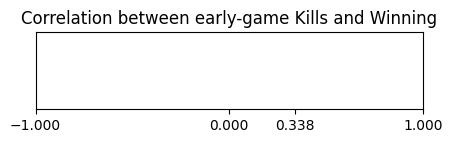

In [860]:
plot_x_axis('Correlation between early-game Kills and Winning', correlation)

There are reasons to believe that there is a very high correlation between the number of early-game kills and games won.

Now let's analyze how much First Blood impacts the game

In [861]:
sum((data['Wins']==1) & (data['FirstBlood']==1))

5936

In [862]:
len(data[(data['Wins']==1) & (data['FirstBlood']==1)])

5936

In [863]:
n_w1_f1 = sum((data['Wins']==1) & (data['FirstBlood']==1)) #Number of games won with first blood
n_w0_f1 = sum((data['Wins']==0) & (data['FirstBlood']==1)) #Number of games lost with first blood
n_w1_f0 = sum((data['Wins']==1) & (data['FirstBlood']==0)) #Number of games lost without first blood
n_w0_f0 = sum((data['Wins']==0) & (data['FirstBlood']==0)) #Number of games lost without first blood
n_w1 = sum(data['Wins']==1)
n_w0 = sum(data['Wins']==0)
n_f1 = sum(data['FirstBlood']==1)
n_f0 = sum(data['FirstBlood']==0)

Let's see what % of games won drew a first blood

In [864]:
print((n_w1_f1 / n_w1)*100, '%')

60.087053345480314 %


60% of games won drew a first blood. Is this value enough to reason that there might be a correlation between first bloods and games won? Let's find the phi coefficient between them to find out.

In [865]:
phi = (n_w1_f1 * n_w0_f0 - n_w1_f0 * n_w0_f1)/np.sqrt((n_w1 * n_f1 * n_w0 * n_f0))
np.round(phi,5)

0.20174

In [866]:
correlation_first_blood = phi

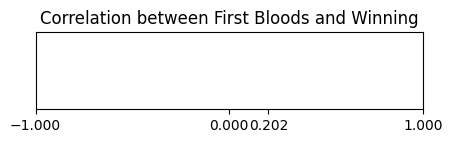

In [867]:
plot_x_axis('Correlation between First Bloods and Winning',phi)

We can suspect that there is a noticeable correlation between First Bloods and Wins, considering the phi value to be ~0.2

Let's check the impact early pushing has to the game

In [868]:
correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data['TowersDestroyed'])

print(f"Point-Biserial Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Point-Biserial Correlation: 0.1097
P-value: 0.0000


In [869]:
correlation_towers_destroyed = correlation

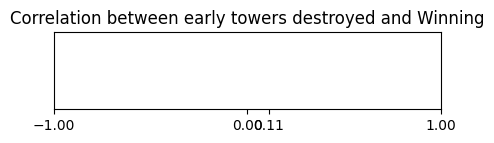

In [870]:
plot_x_axis('Correlation between early towers destroyed and Winning', correlation)

Let's make a list of the most important parameters and see their correlations to the wins

In [871]:
important_parameters = list(data.columns)
important_parameters.remove('gameId')
important_parameters.remove('Wins')
important_parameters.remove('FirstBlood')

In [872]:
d = {}

for parameter in important_parameters:
    correlation, p_value = stats.pointbiserialr(y=data['Wins'], x=data[parameter])
    d[parameter] = correlation

d['FirstBlood'] = correlation_first_blood

In [873]:
# Sorting the values
d = dict(sorted(d.items(), key=lambda item: item[1]))

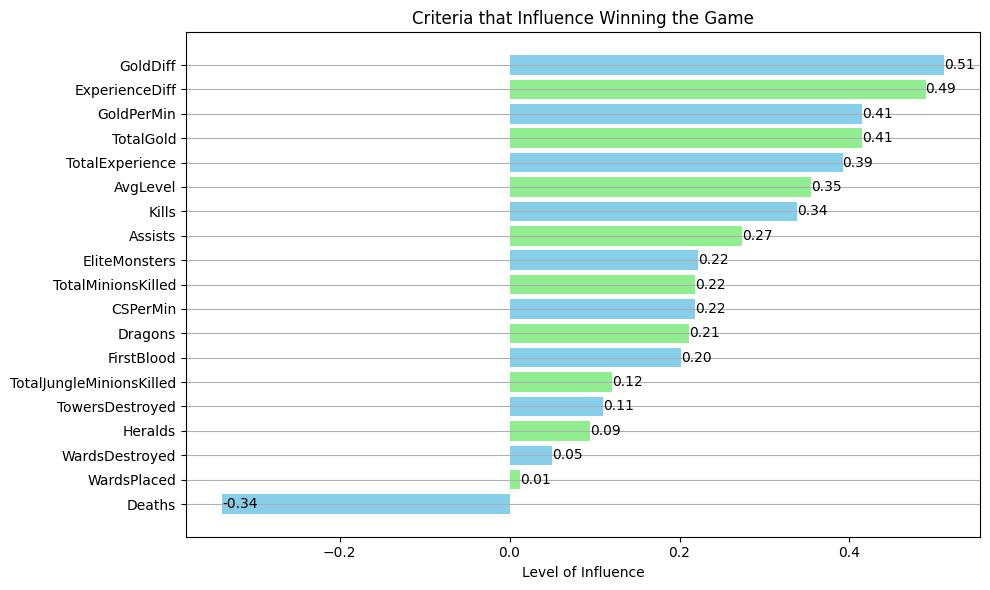

In [874]:
labels = list(d.keys())
values = list(d.values())


plt.figure(figsize=(10, 6))  
colors = ['skyblue' if i % 2 == 0 else 'lightgreen' for i in range(len(labels))]
bars = plt.barh(labels, values, color=colors)
plt.xlabel('Level of Influence')
plt.title('Criteria that Influence Winning the Game')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.grid()

plt.tight_layout()
plt.show()

Let's make a model to predict the outcome on the game with the details every player has on their scoreboard:
- Dragons
- Heralds
- Towers
- Kills

In [875]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [876]:
X = data[['Kills', 'Dragons', 'Heralds', 'TowersDestroyed']]
Y = data['Wins']

Testing different data normalization tecnhiques to see which improves the accurracy of our model.

In [877]:
#NO NORMALIZATION

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521



In [878]:
#MIN MAX NORMALIZATION

for column in X.columns:
    X[column] = (X[column] - min(X[column]))/(max(X[column]) - min(X[column]))


In [879]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6548075448550835
Confusion Matrix:
 [[2240 1056]
 [1195 2030]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.65      6521
   macro avg       0.65      0.65      0.65      6521
weighted avg       0.65      0.65      0.65      6521



In [880]:
#Z-SCORE NORMALIZATION

for column in X.columns:
    X[column] = stats.zscore(X[column])

In [881]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
model = LogisticRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521



Normalization has no effect on the accurracy of the model

In [882]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [883]:
model = LogisticRegression()
model.fit(X_train, Y_train)


LogisticRegression()

In [884]:
Y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Accuracy: 0.6555742984204876
Confusion Matrix:
 [[2238 1058]
 [1188 2037]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      3296
           1       0.66      0.63      0.64      3225

    accuracy                           0.66      6521
   macro avg       0.66      0.66      0.66      6521
weighted avg       0.66      0.66      0.66      6521

